## Long short-term memory(LSTM) + ATTENTION Implementation


Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re

C:\Users\u61152\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading already clean dataset
imf = pd.read_excel("data/WEOOct2020all_clean.xls", na_values=['--'])

In [4]:
imf.shape

(8083, 48)

In [5]:
# Let's take a look at the first few rows
imf.head(10)

,Unnamed: 0,Country,Year,BCA,Current_account_balance(GDP%),FLIBOR6,GDP_cons_price(%),GDP_current_prices(USD_Billion),GGR,GGR_NGDP,...,PCPIE,PPPEX,PPPPC,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH,Unemployment_rate(%),lending/borrowing(GDP%)
0,0,Afghanistan,2002,1.481,33.908,0.0,0.000,19.677,12.235,6.845,...,42.890,9.085,886.227,0.036,0.000,0.000,0.000,0.000,0.0,-0.098
1,1,Afghanistan,2003,1.348,29.616,0.0,8.692,21.784,21.618,9.826,...,45.691,10.100,942.382,0.037,35.018,37.300,87.548,49.262,0.0,-2.102
2,2,Afghanistan,2004,1.915,37.216,0.0,0.671,22.521,31.209,12.676,...,51.752,10.933,937.636,0.036,-0.960,1.403,-27.364,-5.861,0.0,-2.393
3,3,Afghanistan,2005,1.864,30.226,0.0,11.830,25.969,44.926,14.733,...,57.219,11.742,1044.589,0.038,51.689,55.435,17.543,46.497,0.0,-0.965
4,4,Afghanistan,2006,1.444,20.844,0.0,5.361,28.190,65.518,18.946,...,59.671,12.268,1099.814,0.038,-1.056,-2.324,-33.218,-7.933,0.0,0.643
5,5,Afghanistan,2007,5.424,63.390,0.0,13.340,32.808,81.163,18.986,...,69.273,13.030,1232.621,0.041,-15.195,-9.869,39.065,-10.109,0.0,-2.492
6,6,Afghanistan,2008,3.477,33.769,0.0,3.863,34.739,88.162,17.036,...,82.306,14.897,1272.751,0.041,-2.958,-7.882,50.728,-6.911,0.0,-3.882
7,7,Afghanistan,2009,5.018,41.587,0.0,20.585,42.209,117.745,19.391,...,74.211,14.386,1507.225,0.050,25.444,28.046,-20.600,31.230,0.0,-1.779
8,8,Afghanistan,2010,4.510,29.430,0.0,8.438,46.304,154.612,21.722,...,81.814,15.371,1607.598,0.052,33.425,32.285,-2.964,9.768,0.0,0.922
9,9,Afghanistan,2011,4.754,26.574,0.0,6.479,50.334,177.821,21.265,...,89.433,16.613,1694.256,0.053,8.001,12.751,-10.267,1.786,0.0,-0.672


In [6]:
def get_data_frame(country):
    imf_country = imf[imf['Country']==country]
    return imf_country

In [7]:
IMF_UK = get_data_frame('United Kingdom')

In [8]:
IMF_UK

,Unnamed: 0,Country,Year,BCA,Current_account_balance(GDP%),FLIBOR6,GDP_cons_price(%),GDP_current_prices(USD_Billion),GGR,GGR_NGDP,...,PCPIE,PPPEX,PPPPC,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH,Unemployment_rate(%),lending/borrowing(GDP%)
7625,7625,United Kingdom,1980,3.245,0.537,0.0,-2.031,496.173,94.302,36.318,...,31.758,0.523,8808.318,3.717,-5.344,-3.552,0.927,-0.541,7.133,-2.840
7626,7626,United Kingdom,1981,8.966,1.527,0.0,-0.788,538.837,109.403,37.784,...,35.574,0.537,9560.967,3.626,-3.945,-2.875,-0.958,-0.698,9.650,-3.777
7627,7627,United Kingdom,1982,3.096,0.555,0.0,1.995,583.544,123.550,38.734,...,37.482,0.547,10366.551,3.692,5.454,4.520,2.658,0.821,10.725,-2.275
7628,7628,United Kingdom,1983,1.142,0.215,0.0,4.222,631.999,131.123,37.371,...,39.481,0.555,11222.362,3.755,8.813,6.148,2.172,1.723,11.475,-2.875
7629,7629,United Kingdom,1984,-2.501,-0.496,0.0,2.269,669.662,140.445,37.200,...,41.299,0.564,11871.548,3.680,11.235,9.445,8.055,6.423,11.750,-3.164
7630,7630,United Kingdom,1985,-1.547,-0.288,0.0,4.147,719.494,153.219,36.972,...,43.616,0.576,12722.256,3.702,3.132,2.329,5.503,5.589,11.375,-2.479
7631,7631,United Kingdom,1986,-6.304,-0.962,0.0,3.150,757.102,160.562,35.950,...,45.251,0.590,13356.538,3.689,7.426,6.653,4.359,3.949,11.325,-2.277
7632,7632,United Kingdom,1987,-12.806,-1.575,0.0,5.393,817.666,173.162,34.903,...,46.932,0.607,14394.514,3.745,7.762,7.732,5.909,6.228,10.425,-1.605
7633,7633,United Kingdom,1988,-34.912,-3.528,0.0,5.732,895.026,192.169,34.588,...,50.540,0.621,15725.386,3.789,13.336,12.355,2.110,0.863,8.575,0.327
7634,7634,United Kingdom,1989,-40.911,-4.061,0.0,2.578,954.093,210.611,34.273,...,53.318,0.644,16715.893,3.749,8.175,7.111,5.871,4.608,7.225,0.589


#### Once we have data corresponding each country we dont need now country column also

In [9]:
IMF_UK.drop(['Country'] , axis=1, inplace=True)

In [10]:
IMF_UK.head()

,Unnamed: 0,Year,BCA,Current_account_balance(GDP%),FLIBOR6,GDP_cons_price(%),GDP_current_prices(USD_Billion),GGR,GGR_NGDP,GGSB,...,PCPIE,PPPEX,PPPPC,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH,Unemployment_rate(%),lending/borrowing(GDP%)
7625,7625,1980,3.245,0.537,0.0,-2.031,496.173,94.302,36.318,0.000,...,31.758,0.523,8808.318,3.717,-5.344,-3.552,0.927,-0.541,7.133,-2.840
7626,7626,1981,8.966,1.527,0.0,-0.788,538.837,109.403,37.784,-6.792,...,35.574,0.537,9560.967,3.626,-3.945,-2.875,-0.958,-0.698,9.650,-3.777
7627,7627,1982,3.096,0.555,0.0,1.995,583.544,123.550,38.734,-2.057,...,37.482,0.547,10366.551,3.692,5.454,4.520,2.658,0.821,10.725,-2.275
7628,7628,1983,1.142,0.215,0.0,4.222,631.999,131.123,37.371,-8.466,...,39.481,0.555,11222.362,3.755,8.813,6.148,2.172,1.723,11.475,-2.875
7629,7629,1984,-2.501,-0.496,0.0,2.269,669.662,140.445,37.200,-11.044,...,41.299,0.564,11871.548,3.680,11.235,9.445,8.055,6.423,11.750,-3.164


In [11]:
IMF_UK.reset_index(drop=True)

,Unnamed: 0,Year,BCA,Current_account_balance(GDP%),FLIBOR6,GDP_cons_price(%),GDP_current_prices(USD_Billion),GGR,GGR_NGDP,GGSB,...,PCPIE,PPPEX,PPPPC,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH,Unemployment_rate(%),lending/borrowing(GDP%)
0,7625,1980,3.245,0.537,0.0,-2.031,496.173,94.302,36.318,0.000,...,31.758,0.523,8808.318,3.717,-5.344,-3.552,0.927,-0.541,7.133,-2.840
1,7626,1981,8.966,1.527,0.0,-0.788,538.837,109.403,37.784,-6.792,...,35.574,0.537,9560.967,3.626,-3.945,-2.875,-0.958,-0.698,9.650,-3.777
2,7627,1982,3.096,0.555,0.0,1.995,583.544,123.550,38.734,-2.057,...,37.482,0.547,10366.551,3.692,5.454,4.520,2.658,0.821,10.725,-2.275
3,7628,1983,1.142,0.215,0.0,4.222,631.999,131.123,37.371,-8.466,...,39.481,0.555,11222.362,3.755,8.813,6.148,2.172,1.723,11.475,-2.875
4,7629,1984,-2.501,-0.496,0.0,2.269,669.662,140.445,37.200,-11.044,...,41.299,0.564,11871.548,3.680,11.235,9.445,8.055,6.423,11.750,-3.164
5,7630,1985,-1.547,-0.288,0.0,4.147,719.494,153.219,36.972,-10.907,...,43.616,0.576,12722.256,3.702,3.132,2.329,5.503,5.589,11.375,-2.479
6,7631,1986,-6.304,-0.962,0.0,3.150,757.102,160.562,35.950,-10.706,...,45.251,0.590,13356.538,3.689,7.426,6.653,4.359,3.949,11.325,-2.277
7,7632,1987,-12.806,-1.575,0.0,5.393,817.666,173.162,34.903,-12.206,...,46.932,0.607,14394.514,3.745,7.762,7.732,5.909,6.228,10.425,-1.605
8,7633,1988,-34.912,-3.528,0.0,5.732,895.026,192.169,34.588,-7.437,...,50.540,0.621,15725.386,3.789,13.336,12.355,2.110,0.863,8.575,0.327
9,7634,1989,-40.911,-4.061,0.0,2.578,954.093,210.611,34.273,-10.203,...,53.318,0.644,16715.893,3.749,8.175,7.111,5.871,4.608,7.225,0.589


In [12]:
IMF_UK.drop(['Year'] , axis=1, inplace=True)

In [13]:
##### Now this data is ready to LSTM

In [14]:
IMF_UK

,Unnamed: 0,BCA,Current_account_balance(GDP%),FLIBOR6,GDP_cons_price(%),GDP_current_prices(USD_Billion),GGR,GGR_NGDP,GGSB,GGSB_NPGDP,...,PCPIE,PPPEX,PPPPC,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH,Unemployment_rate(%),lending/borrowing(GDP%)
7625,7625,3.245,0.537,0.0,-2.031,496.173,94.302,36.318,0.000,0.000,...,31.758,0.523,8808.318,3.717,-5.344,-3.552,0.927,-0.541,7.133,-2.840
7626,7626,8.966,1.527,0.0,-0.788,538.837,109.403,37.784,-6.792,-2.282,...,35.574,0.537,9560.967,3.626,-3.945,-2.875,-0.958,-0.698,9.650,-3.777
7627,7627,3.096,0.555,0.0,1.995,583.544,123.550,38.734,-2.057,-0.631,...,37.482,0.547,10366.551,3.692,5.454,4.520,2.658,0.821,10.725,-2.275
7628,7628,1.142,0.215,0.0,4.222,631.999,131.123,37.371,-8.466,-2.410,...,39.481,0.555,11222.362,3.755,8.813,6.148,2.172,1.723,11.475,-2.875
7629,7629,-2.501,-0.496,0.0,2.269,669.662,140.445,37.200,-11.044,-2.912,...,41.299,0.564,11871.548,3.680,11.235,9.445,8.055,6.423,11.750,-3.164
7630,7630,-1.547,-0.288,0.0,4.147,719.494,153.219,36.972,-10.907,-2.638,...,43.616,0.576,12722.256,3.702,3.132,2.329,5.503,5.589,11.375,-2.479
7631,7631,-6.304,-0.962,0.0,3.150,757.102,160.562,35.950,-10.706,-2.394,...,45.251,0.590,13356.538,3.689,7.426,6.653,4.359,3.949,11.325,-2.277
7632,7632,-12.806,-1.575,0.0,5.393,817.666,173.162,34.903,-12.206,-2.498,...,46.932,0.607,14394.514,3.745,7.762,7.732,5.909,6.228,10.425,-1.605
7633,7633,-34.912,-3.528,0.0,5.732,895.026,192.169,34.588,-7.437,-1.388,...,50.540,0.621,15725.386,3.789,13.336,12.355,2.110,0.863,8.575,0.327
7634,7634,-40.911,-4.061,0.0,2.578,954.093,210.611,34.273,-10.203,-1.717,...,53.318,0.644,16715.893,3.749,8.175,7.111,5.871,4.608,7.225,0.589


In [15]:
IMF_UK.reset_index(drop=True)

,Unnamed: 0,BCA,Current_account_balance(GDP%),FLIBOR6,GDP_cons_price(%),GDP_current_prices(USD_Billion),GGR,GGR_NGDP,GGSB,GGSB_NPGDP,...,PCPIE,PPPEX,PPPPC,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH,Unemployment_rate(%),lending/borrowing(GDP%)
0,7625,3.245,0.537,0.0,-2.031,496.173,94.302,36.318,0.000,0.000,...,31.758,0.523,8808.318,3.717,-5.344,-3.552,0.927,-0.541,7.133,-2.840
1,7626,8.966,1.527,0.0,-0.788,538.837,109.403,37.784,-6.792,-2.282,...,35.574,0.537,9560.967,3.626,-3.945,-2.875,-0.958,-0.698,9.650,-3.777
2,7627,3.096,0.555,0.0,1.995,583.544,123.550,38.734,-2.057,-0.631,...,37.482,0.547,10366.551,3.692,5.454,4.520,2.658,0.821,10.725,-2.275
3,7628,1.142,0.215,0.0,4.222,631.999,131.123,37.371,-8.466,-2.410,...,39.481,0.555,11222.362,3.755,8.813,6.148,2.172,1.723,11.475,-2.875
4,7629,-2.501,-0.496,0.0,2.269,669.662,140.445,37.200,-11.044,-2.912,...,41.299,0.564,11871.548,3.680,11.235,9.445,8.055,6.423,11.750,-3.164
5,7630,-1.547,-0.288,0.0,4.147,719.494,153.219,36.972,-10.907,-2.638,...,43.616,0.576,12722.256,3.702,3.132,2.329,5.503,5.589,11.375,-2.479
6,7631,-6.304,-0.962,0.0,3.150,757.102,160.562,35.950,-10.706,-2.394,...,45.251,0.590,13356.538,3.689,7.426,6.653,4.359,3.949,11.325,-2.277
7,7632,-12.806,-1.575,0.0,5.393,817.666,173.162,34.903,-12.206,-2.498,...,46.932,0.607,14394.514,3.745,7.762,7.732,5.909,6.228,10.425,-1.605
8,7633,-34.912,-3.528,0.0,5.732,895.026,192.169,34.588,-7.437,-1.388,...,50.540,0.621,15725.386,3.789,13.336,12.355,2.110,0.863,8.575,0.327
9,7634,-40.911,-4.061,0.0,2.578,954.093,210.611,34.273,-10.203,-1.717,...,53.318,0.644,16715.893,3.749,8.175,7.111,5.871,4.608,7.225,0.589


In [16]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =list(), list()
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_features
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [17]:
from numpy import array
from numpy import hstack
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [18]:
IMF_UK.values

array([[ 7.62500e+03,  3.24500e+00,  5.37000e-01, ..., -5.41000e-01,
         7.13300e+00, -2.84000e+00],
       [ 7.62600e+03,  8.96600e+00,  1.52700e+00, ..., -6.98000e-01,
         9.65000e+00, -3.77700e+00],
       [ 7.62700e+03,  3.09600e+00,  5.55000e-01, ...,  8.21000e-01,
         1.07250e+01, -2.27500e+00],
       ...,
       [ 7.66700e+03, -1.10595e+02, -3.54500e+00, ...,  1.92500e+00,
         5.16500e+00, -5.77400e+00],
       [ 7.66800e+03, -1.11393e+02, -3.43900e+00, ...,  2.10300e+00,
         4.45800e+00, -5.10700e+00],
       [ 7.66900e+03, -1.11847e+02, -3.33200e+00, ...,  2.12300e+00,
         4.20000e+00, -4.44700e+00]])

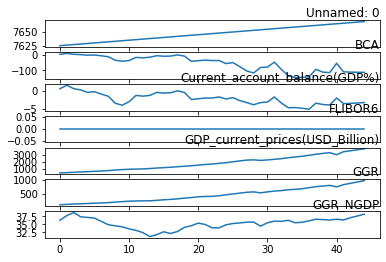

In [19]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
values = IMF_UK.values
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(IMF_UK.columns[group], y=0.9, loc='right')
    i += 1
plt.show()

In [20]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
#X
imf_scaled = scaler.fit_transform(np.float32(IMF_UK))

In [21]:
imf_scaled

array([[0.        , 0.9627827 , 0.8530721 , ..., 0.5216924 , 0.4174132 ,
        0.7643626 ],
       [0.0227356 , 0.99999994, 0.99999994, ..., 0.5158707 , 0.73501575,
        0.71179307],
       [0.04545593, 0.9618134 , 0.8557435 , ..., 0.5721967 , 0.87066245,
        0.7960614 ],
       ...,
       [0.95454407, 0.22221065, 0.24725437, ..., 0.61313415, 0.16908512,
        0.5997531 ],
       [0.97727966, 0.21701938, 0.26298606, ..., 0.6197345 , 0.07987383,
        0.63717455],
       [1.        , 0.21406591, 0.2788661 , ..., 0.6204762 , 0.04731855,
        0.6742033 ]], dtype=float32)

In [22]:
# define input sequence
# choose a number of time steps
n_steps = 4
# split into samples
x_data, y_data = prepare_data(imf_scaled, n_steps)

In [23]:
print(x_data)

[[[0.         0.9627827  0.8530721  ... 0.5216924  0.4174132  0.7643626 ]
  [0.0227356  0.99999994 0.99999994 ... 0.5158707  0.73501575 0.71179307]
  [0.04545593 0.9618134  0.8557435  ... 0.5721967  0.87066245 0.7960614 ]
  [0.06819153 0.94910187 0.8052834  ... 0.60564375 0.9652997  0.76239896]]

 [[0.0227356  0.99999994 0.99999994 ... 0.5158707  0.73501575 0.71179307]
  [0.04545593 0.9618134  0.8557435  ... 0.5721967  0.87066245 0.7960614 ]
  [0.06819153 0.94910187 0.8052834  ... 0.60564375 0.9652997  0.76239896]
  [0.09091187 0.9254028  0.6997625  ... 0.7799244  1.         0.7461848 ]]

 [[0.04545593 0.9618134  0.8557435  ... 0.5721967  0.87066245 0.7960614 ]
  [0.06819153 0.94910187 0.8052834  ... 0.60564375 0.9652997  0.76239896]
  [0.09091187 0.9254028  0.6997625  ... 0.7799244  1.         0.7461848 ]
  [0.11364746 0.9316089  0.7306322  ... 0.7489989  0.9526813  0.7846162 ]]

 ...

 [[0.86364746 0.22156662 0.19976252 ... 0.5872516  0.03154573 0.79667854]
  [0.8863678  0.20363134 0

In [24]:
print(y_data)

[[0.09091187 0.9254028  0.6997625  ... 0.7799244  1.         0.7461848 ]
 [0.11364746 0.9316089  0.7306322  ... 0.7489989  0.9526813  0.7846162 ]
 [0.1363678  0.90066284 0.63060254 ... 0.68818605 0.94637215 0.7959492 ]
 ...
 [0.95454407 0.22221065 0.24725437 ... 0.61313415 0.16908512 0.5997531 ]
 [0.97727966 0.21701938 0.26298606 ... 0.6197345  0.07987383 0.63717455]
 [1.         0.21406591 0.2788661  ... 0.6204762  0.04731855 0.6742033 ]]


In [25]:
x_data.shape

(41, 4, 46)

In [26]:
y_data.shape

(41, 46)

In [27]:
print(x_data, y_data.shape)
# summarize the data
for i in range(len(x_data)):
    print(x_data[i], y_data[i])

[[[0.         0.9627827  0.8530721  ... 0.5216924  0.4174132  0.7643626 ]
  [0.0227356  0.99999994 0.99999994 ... 0.5158707  0.73501575 0.71179307]
  [0.04545593 0.9618134  0.8557435  ... 0.5721967  0.87066245 0.7960614 ]
  [0.06819153 0.94910187 0.8052834  ... 0.60564375 0.9652997  0.76239896]]

 [[0.0227356  0.99999994 0.99999994 ... 0.5158707  0.73501575 0.71179307]
  [0.04545593 0.9618134  0.8557435  ... 0.5721967  0.87066245 0.7960614 ]
  [0.06819153 0.94910187 0.8052834  ... 0.60564375 0.9652997  0.76239896]
  [0.09091187 0.9254028  0.6997625  ... 0.7799244  1.         0.7461848 ]]

 [[0.04545593 0.9618134  0.8557435  ... 0.5721967  0.87066245 0.7960614 ]
  [0.06819153 0.94910187 0.8052834  ... 0.60564375 0.9652997  0.76239896]
  [0.09091187 0.9254028  0.6997625  ... 0.7799244  1.         0.7461848 ]
  [0.11364746 0.9316089  0.7306322  ... 0.7489989  0.9526813  0.7846162 ]]

 ...

 [[0.86364746 0.22156662 0.19976252 ... 0.5872516  0.03154573 0.79667854]
  [0.8863678  0.20363134 0

In [28]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(x_data, test_size=0.2)
train_y, test_y = train_test_split(y_data, test_size=0.2)

In [29]:
train_x.shape

(32, 4, 46)

In [30]:
train_y.shape

(32, 46)

In [31]:
test_x.shape

(9, 4, 46)

In [32]:
test_y.shape

(9, 46)

In [33]:
train_x

array([[[0.6363678 , 0.18637908, 0.18996733, ..., 0.5907743 ,
         0.23974761, 0.6349865 ],
        [0.65908813, 0.41705972, 0.2787177 , ..., 0.25244737,
         0.4794952 , 0.35805655],
        [0.68182373, 0.43057787, 0.30276045, ..., 0.756378  ,
         0.51419556, 0.40305203],
        [0.70454407, 0.6367723 , 0.51187295, ..., 0.81088704,
         0.53943217, 0.5024686 ]],

       [[0.79545593, 0.00686324, 0.04526561, ..., 0.6816969 ,
         0.19558355, 0.6661243 ],
        [0.8181915 , 0.0248701 , 0.        , ..., 0.64320683,
         0.1324921 , 0.7358617 ],
        [0.84091187, 0.3357945 , 0.255417  , ..., 0.76798433,
         0.07570979, 0.786131  ],
        [0.86364746, 0.22156662, 0.19976252, ..., 0.5872516 ,
         0.03154573, 0.79667854]],

       [[0.54545593, 0.57612264, 0.4284654 , ..., 0.70246226,
         0.11671922, 0.75140256],
        [0.5681915 , 0.6194354 , 0.4841199 , ..., 0.8385495 ,
         0.12618294, 0.74708253],
        [0.59091187, 0.44888398, 0.3

In [34]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(train_x.shape[2]))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_x, train_y, epochs=400, verbose=0)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [35]:
preds = model.predict(test_x).squeeze()
mean_absolute_error(preds, test_y)

0.23203968

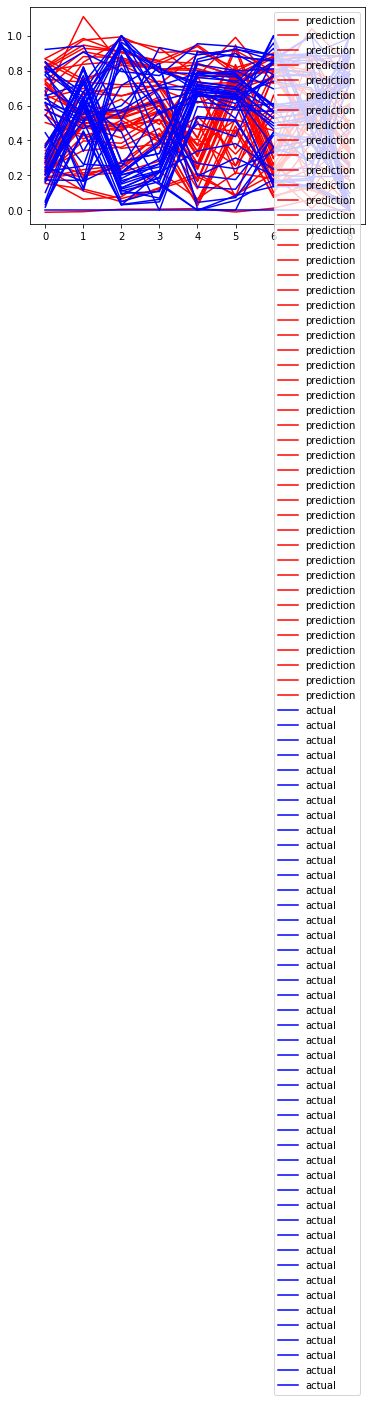

In [36]:
plt.plot(preds,color='red', label='prediction')
plt.plot(test_y,color='blue', label='actual')
plt.legend(loc='upper right')
plt.show()